In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor
from RecData import RecData

In [2]:
recs = pd.read_csv('data/pruned.csv')
USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

train_data, test = rec_data.leave_k_out_split()
train_data, val = train_data.leave_k_out_split()

Epoch 0/Training error: 0.37448699894099186/Validation error: 0.3700393072793054/Time: 117.68 seconds
Epoch 1/Training error: 0.3706897367439541/Validation error: 0.3672375992082647/Time: 120.04 seconds
Epoch 2/Training error: 0.36803523232412505/Validation error: 0.36533726631859686/Time: 119.0 seconds
Epoch 3/Training error: 0.3658157408625244/Validation error: 0.3637994823584523/Time: 124.98 seconds
Epoch 4/Training error: 0.36387452663035824/Validation error: 0.36243093063425436/Time: 122.06 seconds
Epoch 5/Training error: 0.36210400021489203/Validation error: 0.3611746417310917/Time: 116.47 seconds
Epoch 6/Training error: 0.36048933285503354/Validation error: 0.360043242694466/Time: 117.94 seconds
Epoch 7/Training error: 0.3589915974795005/Validation error: 0.35897901874285665/Time: 123.4 seconds
Epoch 8/Training error: 0.3575816270446801/Validation error: 0.3579657259445354/Time: 120.22 seconds
Epoch 9/Training error: 0.3562532945982808/Validation error: 0.3569821160116157/Time: 

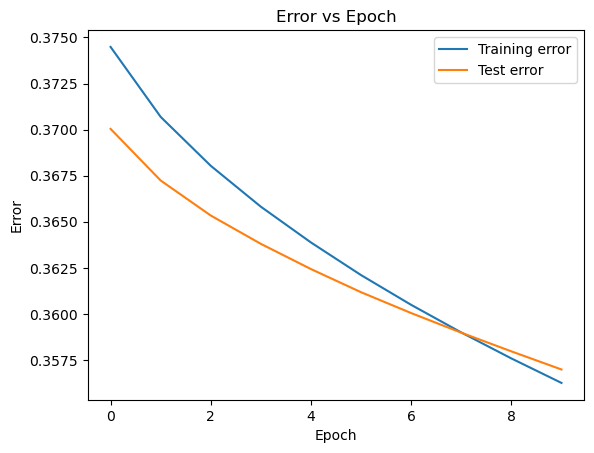

Test rmse 0.3569821160116157
Saving model...
Done saving model.


In [4]:
EPOCHS = 10

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = SVDPredictor(
    train_data.get_num_users(), train_data.get_num_items(), k=20, epochs=EPOCHS, 
    learning_rate=0.001, C=0.02)
svd_predictor.fit(train_data.get_matrix(), validation_set=val)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [ ]:
rec_data.search_title('1330')

In [14]:
prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
         (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (544, 0), (312, 0), (277, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(606, 'Stardew Valley', 1),
 (1628, 'The Sims™ 4', 1),
 (391, 'Mortal Kombat X', 0),
 (1330, 'Mortal Kombat\xa011', 0),
 (500, 'Total War: WARHAMMER', 0),
 (709, 'UNO', 1),
 (840, 'MONOPOLY® PLUS', 0),
 (58, 'SPORE™', 1),
 (456, 'Choice of Robots', 1),
 (153, 'Infested Planet', 0),
 (158, 'Gunpoint', 0),
 (1160, 'Cosmoteer: Starship Architect & Commander', 0),
 (761, 'Glass Masquerade', 0),
 (1771, 'Against the Storm', 0),
 (544, 'Aviary Attorney', 0),
 (312, 'Grand Theft Auto V', 0),
 (277, 'Rust', 0)]


In [15]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Training error: 0.3562938940048277/Time: 3.43 seconds
Epoch 1/Training error: 0.35629373258536406/Time: 3.36 seconds
Epoch 2/Training error: 0.35629357671127204/Time: 3.16 seconds
Epoch 3/Training error: 0.35629342625545307/Time: 3.24 seconds
Epoch 4/Training error: 0.35629328085706385/Time: 3.34 seconds
Epoch 5/Training error: 0.3562931404345393/Time: 3.42 seconds
Epoch 6/Training error: 0.3562930045862026/Time: 3.27 seconds
Epoch 7/Training error: 0.3562928733132726/Time: 3.2 seconds
Epoch 8/Training error: 0.3562927465025948/Time: 3.3 seconds
Epoch 9/Training error: 0.356292623864274/Time: 3.21 seconds
Completed partial fit in 32.98696041107178 seconds


In [17]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(1.9076218733543104, 'A Hat in Time'),
 (1.9034784988287023, 'Portal 2'),
 (1.8988644943106179, 'POSTAL 2'),
 (1.8966593347906735, 'Terraria'),
 (1.8933959419222457, 'DOOM (1993)'),
 (1.8922562088992145, 'Neon White'),
 (1.8911714849204737, 'Bastion'),
 (1.8898940932712782, 'OMORI'),
 (1.8894667741788373, 'Keep Talking and Nobody Explodes'),
 (1.8866023255393254, 'Portal'),
 (1.8852818615996563, 'Half-Life 2'),
 (1.8836152254646399, 'ULTRAKILL'),
 (1.8829275706298338, 'Cookie Clicker'),
 (1.882713601038485, 'Ultimate Chicken Horse'),
 (1.8826768031745644, 'DUSK'),
 (1.8817620328368292, 'Persona 5 Royal'),
 (1.8815784777870808, 'POSTAL: Brain Damaged'),
 (1.8803338519033272, 'Outer Wilds'),
 (1.880106383818281, 'Monolith'),
 (1.878504350991103, "Sid Meier's Civilization® V")]
